# An ML-Augmented Pairs Trading Strategy




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pairs Finding:

*   Using an autoencoder to reduce dimensionality of time series
*   Apply clustering to find optimal groups
*   Use pairwise co-integration tests among groups
*   Use a financial LLM to ask if the stocks are in same industry



# PairsFinder Class Documentation

## Overview
The `PairsFinder` class is designed to streamline the process of identifying cointegrated pairs for pairs trading strategies. It automates several key steps: data loading, data splitting, return preprocessing, autoencoder training for dimensionality reduction, asset clustering, and cointegration analysis combined with a Hurst exponent test to select mean-reverting pairs.

## Key Features

- **Data Loading:**  
  Automatically downloads historical price data using yfinance if a local CSV file does not exist.

- **Data Splitting:**  
  Splits the loaded data into training and testing sets based on a customizable split ratio.

- **Preprocessing:**  
  Computes percentage returns and applies standard scaling while filtering out assets with no variation.

- **Autoencoder Training:**  
  Reduces the dimensionality of the asset returns using a customizable autoencoder, with options to adjust:
  - Encoding dimension
  - Number of epochs
  - Learning rate
  - Hidden layer size

- **Clustering:**  
  Clusters assets using KMeans on the encoded returns.  
  *Note:* If the number of clusters is not specified, it defaults to approximately one-fourth of the number of assets.

- **Cointegration Analysis:**  
  Evaluates asset pairs for cointegration (using a p-value threshold) and tests for mean reversion by computing the Hurst exponent of the spread.

- **Pipeline Execution:**  
  The `run_pipeline()` method ties all steps together for a seamless end-to-end analysis.

- **Logging:**  
  Uses Python’s logging module to provide status updates and debug information throughout the process.

## Usage Example

```python
import pandas as pd
import logging
from pairsfinder import PairsFinder  # Adjust import based on your module location

# Load tickers (assumes 'russel3000_stocks.csv' exists)
tickers = pd.read_csv('russel3000_stocks.csv')['Ticker'].tolist()

# Optional: Customize autoencoder and clustering parameters
autoencoder_params = {
    'encoding_dim': 10,     # 10-dimensional latent space
    'num_epochs': 500,      # Train for 500 epochs
    'lr': 0.005,            # Learning rate of 0.005
    'print_every': 25,      # Log every 25 epochs
    'hidden_dim': 128       # Hidden layer size of 128 neurons
}

clustering_params = {
    'num_clusters': 100,    # Set number of clusters to 100
    'random_state': 123     # Specific random state for reproducibility
}

# Other custom settings
cointegration_threshold = 0.05
hurst_threshold = 0.45
min_cluster_size = 4
split_ratio = 0.6

# Instantiate the PairsFinder class with custom parameters
pf = PairsFinder(
    tickers=tickers,
    start="2019-01-01",
    end="2025-01-01",
    autoencoder_params=autoencoder_params,
    clustering_params=clustering_params,
    cointegration_threshold=cointegration_threshold,
    hurst_threshold=hurst_threshold,
    min_cluster_size=min_cluster_size,
    split_ratio=split_ratio,
    log_level=logging.INFO  # Change to logging.DEBUG for more details
)

# Run the complete pipeline and save the resulting pairs to a CSV file
pairs_df = pf.run_pipeline()
pf.save_pairs("custom_pairs_df.csv")




In [85]:
import os
import logging
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
import warnings

warnings.filterwarnings("ignore")

class PairsFinder():
    class Autoencoder(nn.Module):
        def __init__(self, input_dim: int, encoding_dim: int = 5, hidden_dim: int = 64):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, encoding_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(encoding_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim)
            )

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    def __init__(self,
                 tickers: list,
                 start: str = "2019-01-01",
                 end: str = "2025-01-01",
                 full_data_file: str = "russel_data_full.csv",
                 train_file: str = "russel_data_train.csv",
                 test_file: str = "russel_data_test.csv",
                 autoencoder_params: dict = None,
                 clustering_params: dict = None,
                 cointegration_threshold: float = 0.05,
                 hurst_threshold: float = 0.5,
                 min_cluster_size: int = 3,
                 split_ratio: float = 0.5,
                 log_level: int = logging.INFO):
        """
        Initialize PairsFinder with customization options.
        """
        self.tickers = tickers
        self.start = start
        self.end = end
        self.full_data_file = full_data_file
        self.train_file = train_file
        self.test_file = test_file
        self.split_ratio = split_ratio

        self.cointegration_threshold = cointegration_threshold
        self.hurst_threshold = hurst_threshold
        self.min_cluster_size = min_cluster_size

        self.autoencoder_params = autoencoder_params if autoencoder_params is not None else {
            'encoding_dim': 5, 'num_epochs': 1000, 'lr': 0.01, 'print_every': 50, 'hidden_dim': 64
        }
        self.clustering_params = clustering_params if clustering_params is not None else {
            'num_clusters': None, 'random_state': 42
        }

        self.full_data = None
        self.train_data = None
        self.test_data = None
        self.scaled_returns = None
        self.asset_names = None
        self.encoded_returns = None
        self.asset_clusters = None
        self.pairs_df = pd.DataFrame()

        logging.basicConfig(level=log_level, force=True)
        self.logger = logging.getLogger(__name__)

    def load_full_data(self) -> pd.DataFrame:
        """Load full data from CSV if it exists; otherwise, download and save."""
        if os.path.exists(self.full_data_file):
            self.full_data = pd.read_csv(self.full_data_file, parse_dates=['Date'], index_col='Date')
            self.logger.info("Loaded full data from file.")
        else:
            self.logger.info("Downloading full data ...")
            data = yf.download(self.tickers, start=self.start, end=self.end)['Close']
            data.to_csv(self.full_data_file)
            self.full_data = data
            self.logger.info("Downloaded and saved full data.")
        return self.full_data

    def split_data(self) -> tuple:
        """Split full data into train and test sets and save them."""
        if self.full_data is None:
            self.load_full_data()
        split_idx = int(self.full_data.shape[0] * self.split_ratio)
        self.train_data = self.full_data.iloc[:split_idx].copy()
        self.test_data = self.full_data.iloc[split_idx:].copy()
        self.train_data.to_csv(self.train_file)
        self.test_data.to_csv(self.test_file)
        self.logger.info(f"Data split into train ({split_idx} rows) and test, and saved.")
        return self.train_data, self.test_data

    def preprocess_returns(self) -> np.ndarray:
        """
        Calculate percent returns, standardize, and filter out assets with all-zero returns.
        Returns:
            Scaled returns as a NumPy array with assets as rows.
        """
        returns = self.train_data.pct_change().iloc[1:].fillna(0)
        scaler = StandardScaler()
        scaled = scaler.fit_transform(returns)
        # Transpose so that each asset is a row
        scaled = scaled.T
        valid_idx = np.where(~np.all(scaled == 0, axis=1))[0]
        self.scaled_returns = scaled[valid_idx]
        self.asset_names = returns.columns[valid_idx]
        self.logger.info(f"Preprocessed returns for {self.scaled_returns.shape[0]} assets.")
        return self.scaled_returns

    def train_autoencoder(self) -> tuple:
        """
        Train an autoencoder on the scaled returns and obtain the encoded representation.
        Returns:
            Tuple of encoded returns (as a NumPy array) and the trained model.
        """
        if self.scaled_returns is None:
            self.preprocess_returns()
        X_train = torch.tensor(self.scaled_returns, dtype=torch.float32)
        input_dim = X_train.shape[1]
        encoding_dim = self.autoencoder_params.get('encoding_dim', 5)
        hidden_dim = self.autoencoder_params.get('hidden_dim', 64)
        model = self.Autoencoder(input_dim, encoding_dim, hidden_dim)
        optimizer = optim.Adam(model.parameters(), lr=self.autoencoder_params.get('lr', 0.01))
        criterion = nn.MSELoss()
        num_epochs = self.autoencoder_params.get('num_epochs', 1000)
        print_every = self.autoencoder_params.get('print_every', 50)

        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            reconstructed = model(X_train)
            loss = criterion(reconstructed, X_train)
            loss.backward()
            optimizer.step()
            if epoch % print_every == 0:
                self.logger.info(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        model.eval()
        with torch.no_grad():
            self.encoded_returns = model.encoder(X_train).numpy()
        self.logger.info("Autoencoder training complete.")
        return self.encoded_returns, model

    def cluster_assets(self) -> pd.DataFrame:
        """
        Cluster assets using KMeans on the encoded returns.
        Returns:
            DataFrame mapping each asset to its cluster.
        """
        if self.encoded_returns is None:
            self.train_autoencoder()
        num_clusters = self.clustering_params.get('num_clusters', None)
        if num_clusters is None:
            num_clusters = max(1, int(self.encoded_returns.shape[0] / 4))
        kmeans = KMeans(n_clusters=num_clusters, random_state=self.clustering_params.get('random_state', 42))
        clusters = kmeans.fit_predict(self.encoded_returns)
        self.asset_clusters = pd.DataFrame({
            "Asset": self.asset_names,
            "Cluster": clusters
        })
        self.logger.info(f"Assets clustered into {num_clusters} clusters.")
        return self.asset_clusters

    @staticmethod
    def calculate_hurst_exponent(series: np.ndarray) -> float:
        """
        Calculate the Hurst exponent for a given series.
        Args:
            series: 1D NumPy array representing a time series.
        Returns:
            Hurst exponent or None if calculation fails.
        """
        try:
            H, _, _ = compute_Hc(series, kind='price', simplified=True)
            return H
        except Exception:
            return None

    def find_cointegrated_pairs(self) -> pd.DataFrame:
        """
        Find cointegrated and mean-reverting pairs from clustered assets.
        Processes clusters in order by cluster ID.
        Returns:
            DataFrame containing cointegrated pairs and quality scores.
        """
        if self.asset_clusters is None:
            self.cluster_assets()
        cointegrated_pairs = []
        for cluster_id in sorted(self.asset_clusters["Cluster"].unique()):
            cluster_assets = self.asset_clusters[self.asset_clusters["Cluster"] == cluster_id]
            if len(cluster_assets) < self.min_cluster_size:
                continue
            assets = cluster_assets["Asset"].tolist()
            for i in range(len(assets)):
                for j in range(i + 1, len(assets)):
                    asset1, asset2 = assets[i], assets[j]
                    series1 = self.train_data[asset1].replace([np.inf, -np.inf], np.nan).ffill()
                    series2 = self.train_data[asset2].replace([np.inf, -np.inf], np.nan).ffill()
                    if series1.isnull().any() or series2.isnull().any():
                        self.logger.warning(f"Skipping pair {asset1}-{asset2} due to missing values")
                        continue
                    score, p_value, _ = coint(series1, series2)
                    if p_value < self.cointegration_threshold:
                        spread = series1 - series2
                        H = self.calculate_hurst_exponent(spread.values)
                        if H is not None and H < self.hurst_threshold:
                            cointegrated_pairs.append({
                                'Asset1': asset1,
                                'Asset2': asset2,
                                'P-Value': p_value,
                                'Hurst': H,
                                'Spread_Std': np.std(spread)
                            })
            self.logger.info(f"Cluster {cluster_id} ({len(cluster_assets)} assets): Found {len(cointegrated_pairs)} valid pairs so far.")
        if cointegrated_pairs:
            self.pairs_df = pd.DataFrame(cointegrated_pairs)
            self.pairs_df['P-Value_adj'] = (
                (self.pairs_df['P-Value'] - self.pairs_df['P-Value'].min()) /
                (self.pairs_df['P-Value'].max() - self.pairs_df['P-Value'].min() + 1e-8)
            )
            self.pairs_df['Hurst_adj'] = (
                (self.pairs_df['Hurst'] - self.pairs_df['Hurst'].min()) /
                (self.pairs_df['Hurst'].max() - self.pairs_df['Hurst'].min() + 1e-8)
            )
            self.pairs_df['Quality_Score'] = (1 - self.pairs_df['P-Value_adj']) * (1 - self.pairs_df['Hurst_adj'])
            self.pairs_df.sort_values('Quality_Score', ascending=False, inplace=True)
            self.pairs_df.reset_index(drop=True, inplace=True)
            self.logger.info("Cointegrated pairs found and quality scored.")
        else:
            self.logger.info("No valid cointegrated pairs found meeting the criteria.")
        return self.pairs_df

    def run_pipeline(self) -> pd.DataFrame:
        """Run the full pipeline: load, split, preprocess, encode, cluster, and find pairs."""
        self.logger.info("Starting pairs finding pipeline...")
        self.load_full_data()
        self.logger.info("Full data loaded.")
        self.split_data()
        self.logger.info("Data split into train and test sets.")
        self.preprocess_returns()
        self.logger.info("Returns preprocessed.")
        self.train_autoencoder()
        self.logger.info("Autoencoder trained.")
        self.cluster_assets()
        self.logger.info("Assets clustered.")
        self.find_cointegrated_pairs()
        self.logger.info("Cointegrated pairs found.")
        return self.pairs_df

    def save_pairs(self, filename: str = "pairs_df.csv", index: bool = False) -> None:
        """Save the found pairs to a CSV file."""
        if not self.pairs_df.empty:
            self.pairs_df.to_csv(filename, index=index)
            self.logger.info(f"Pairs saved to {filename}.")
        else:
            self.logger.warning("No pairs to save.")

# tickers = pd.read_csv('russel3000_stocks.csv')['Ticker'].tolist()
# pf = PairsFinder(tickers)
# pairs = pf.run_pipeline()

In [86]:
logging.basicConfig(level=logging.INFO, force=True) # make nb show info level output


#### using all params:
# auto encoding params
autoencoder_params = {
    'encoding_dim': 10, # 10D latent space
    'num_epochs': 500,
    'lr': 0.005, # learnign rate
    'print_every': 25,
    'hidden_dim': 128
}

# cluster params
# clustering_params = {
#     'num_clusters': 100, # more clusters (like ~450) will make code run faster
#     'random_state': 1
# }
# # commenting this out for now bc takes like 20 mins w these params

# other settings
cointegration_threshold = 0.05
hurst_threshold = 0.45
min_cluster_size = 4
split_ratio = 0.6


tickers = pd.read_csv('russel3000_stocks.csv')['Ticker'].tolist()

# pf = PairsFinder(
#     tickers=tickers,
#     start="2019-01-01",
#     end="2025-01-01",
#     autoencoder_params=autoencoder_params,
#     clustering_params=clustering_params,
#     cointegration_threshold=cointegration_threshold,
#     hurst_threshold=hurst_threshold,
#     min_cluster_size=min_cluster_size,
#     split_ratio=split_ratio,
#     log_level=logging.DEBUG  # use logging.DEBUG for more detail / loggin.INFO for less
# )

# or more basic usage:
# pf = PairsFinder(
#     tickers=tickers
# )

# with 100 clusters takes about 15 min to run on T4
# if n_clusters not specified then it does it automatically

pf = PairsFinder(
    tickers=tickers
)

pf.run_pipeline()
pf.save_pairs("pairs_df.csv")

pf.pairs_df

INFO:__main__:Starting pairs finding pipeline...
INFO:__main__:Loaded full data from file.
INFO:__main__:Full data loaded.
INFO:__main__:Data split into train (755 rows) and test, and saved.
INFO:__main__:Data split into train and test sets.
INFO:__main__:Preprocessed returns for 1538 assets.
INFO:__main__:Returns preprocessed.
INFO:__main__:Epoch 0, Loss: 1.022052
INFO:__main__:Epoch 50, Loss: 0.566695
INFO:__main__:Epoch 100, Loss: 0.526416
INFO:__main__:Epoch 150, Loss: 0.513644
INFO:__main__:Epoch 200, Loss: 0.504859
INFO:__main__:Epoch 250, Loss: 0.498246
INFO:__main__:Epoch 300, Loss: 0.492913
INFO:__main__:Epoch 350, Loss: 0.488941
INFO:__main__:Epoch 400, Loss: 0.485611
INFO:__main__:Epoch 450, Loss: 0.482080
INFO:__main__:Epoch 500, Loss: 0.478460
INFO:__main__:Epoch 550, Loss: 0.475725
INFO:__main__:Epoch 600, Loss: 0.474594
INFO:__main__:Epoch 650, Loss: 0.471322
INFO:__main__:Epoch 700, Loss: 0.469938
INFO:__main__:Epoch 750, Loss: 0.468971
INFO:__main__:Epoch 800, Loss: 0.

,Asset1,Asset2,P-Value,Hurst,Spread_Std,P-Value_adj,Hurst_adj,Quality_Score
0,CZNC,FFNW,0.003529,0.369406,0.965429,0.020689,0.000000,9.793105e-01
1,GENC,NL,0.011760,0.448649,1.326831,0.199886,0.613780,3.090198e-01
2,IFF,UHAL,0.019216,0.449253,9.604536,0.362223,0.618452,2.433428e-01
3,PB,UBSI,0.005026,0.465903,3.240889,0.053288,0.747420,2.391203e-01
4,NBTB,NFBK,0.025847,0.436703,1.547824,0.506575,0.521252,2.362262e-01
5,AMGN,BMY,0.026433,0.448243,17.486138,0.519338,0.610632,1.871544e-01
6,ITIC,WD,0.002578,0.479096,10.745225,0.000000,0.849602,1.503984e-01
7,NATH,WEYS,0.021883,0.475370,4.560703,0.420276,0.820741,1.039205e-01
8,ICUI,PINC,0.029532,0.470326,24.301009,0.586802,0.781677,9.021042e-02
9,UTMD,VREX,0.029243,0.475488,7.907423,0.580513,0.821658,7.481209e-02


### Old... see class above for summary

In [11]:
russell_stocks = pd.read_csv('russel3000_stocks.csv')
russell_stocks = russell_stocks['Ticker'].tolist()

In [12]:
tickers = russell_stocks
start="2019-01-01"
end="2025-01-01"
if not os.path.exists('russel_data_full.csv'):
  full_data = yf.download(tickers, start=start, end=end)['Close']
  full_data.to_csv('russel_data_full.csv')

In [13]:
full_data = pd.read_csv('russel_data_full.csv')
full_data['Date'] = pd.to_datetime(full_data['Date'])
full_data.set_index('Date', inplace=True)
split_idx = int(full_data.shape[0] * 0.5)
train_data = full_data[:split_idx]
test_data = full_data[split_idx:]
train_data.to_csv('russel_data_train.csv')
test_data.to_csv('russel_data_test.csv')

[******                13%                       ]  399 of 3029 completed

In [14]:
returns = train_data.pct_change()
returns = returns[1:].fillna(0)

<ipython-input-14-bb89e8cd33c6>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = train_data.pct_change()


In [15]:
returns.head()

,--,A,AA,AAC,AAL,AAN,AAOI,AAON,AAP,AAPL,...,ZION,ZIOP,ZIXI,ZN,ZNGA,ZOES,ZOM,ZS,ZTS,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.0,-0.036839,0.0,0.0,-0.074507,0.0,-0.051637,-0.037069,0.031219,-0.099607,...,-0.005532,0.0,0.0,0.0,0.0,0.0,-0.072000,0.0,-0.034564,0.0
2019-01-04,0.0,0.034614,0.0,0.0,0.065868,0.0,0.031872,0.054486,-0.024808,0.042689,...,0.030714,0.0,0.0,0.0,0.0,0.0,0.068966,0.0,0.039235,0.0
2019-01-07,0.0,0.021234,0.0,0.0,0.028402,0.0,0.009009,0.015164,0.014671,-0.002226,...,0.003989,0.0,0.0,0.0,0.0,0.0,0.008065,0.0,0.006017,0.0
2019-01-08,0.0,0.014660,0.0,0.0,-0.016085,0.0,0.021046,0.004979,-0.006950,0.019063,...,0.009114,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.014894,0.0
2019-01-09,0.0,0.020934,0.0,0.0,0.030845,0.0,0.006871,-0.001652,0.027559,0.016982,...,0.008569,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.003582,0.0


In [16]:
from sklearn.preprocessing import StandardScaler
# Standardize data
scaler = StandardScaler()

# pivot for each stock to be a row
scaled_returns = scaler.fit_transform(returns)
scaled_returns = scaled_returns.T

In [17]:
scaled_returns

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.16446082,  1.88306056,  1.1251854 , ...,  0.25978467,
         0.0793523 ,  0.44545792],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.05148576,  2.13450344,  0.25034232, ...,  0.84462358,
        -0.61097588,  0.55463971],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [18]:
train_data_copy = train_data.copy()

In [19]:
scaled_returns

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.16446082,  1.88306056,  1.1251854 , ...,  0.25978467,
         0.0793523 ,  0.44545792],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.05148576,  2.13450344,  0.25034232, ...,  0.84462358,
        -0.61097588,  0.55463971],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
## get rid of entries where all 0
valid_indices = np.where(~np.all(scaled_returns == 0, axis=1))[0]

#Use valid_indices to index scaled_returns and data
scaled_returns = scaled_returns[valid_indices]
train_data = train_data_copy.iloc[:,valid_indices]  # If data is a DataFrame

[**********************61%****                   ]  1846 of 3029 completed

In [21]:
scaled_returns.shape

(1538, 754)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=5):  # encoding_dim is the latent space size
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Convert data to PyTorch tensors
X_train = torch.tensor(scaled_returns, dtype=torch.float32)

# Model setup
input_dim = X_train.shape[1]
encoding_dim = 5  # Choose latent space dimension
model = Autoencoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the autoencoder
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    reconstructed = model(X_train)
    loss = criterion(reconstructed, X_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


[**********************68%********               ]  2073 of 3029 completed

Epoch 0, Loss: 1.026415


[**********************69%********               ]  2082 of 3029 completed

Epoch 50, Loss: 0.552790


[**********************69%********               ]  2098 of 3029 completed

Epoch 100, Loss: 0.512722


[**********************70%*********              ]  2112 of 3029 completed

Epoch 150, Loss: 0.497915


[**********************70%*********              ]  2127 of 3029 completed

Epoch 200, Loss: 0.488957


[**********************70%*********              ]  2135 of 3029 completed

Epoch 250, Loss: 0.483450


[**********************71%*********              ]  2143 of 3029 completed

Epoch 300, Loss: 0.478623


[**********************71%*********              ]  2148 of 3029 completed

Epoch 350, Loss: 0.474759


[**********************71%*********              ]  2153 of 3029 completed

Epoch 400, Loss: 0.472018


[**********************71%*********              ]  2162 of 3029 completed

Epoch 450, Loss: 0.468598


[**********************72%**********             ]  2171 of 3029 completed

Epoch 500, Loss: 0.467215


[**********************72%**********             ]  2181 of 3029 completed

Epoch 550, Loss: 0.465287


[**********************72%**********             ]  2189 of 3029 completed

Epoch 600, Loss: 0.464068


[**********************73%**********             ]  2197 of 3029 completed

Epoch 650, Loss: 0.462475


[**********************73%**********             ]  2205 of 3029 completed

Epoch 700, Loss: 0.461157


[**********************73%**********             ]  2215 of 3029 completed

Epoch 750, Loss: 0.459625


[**********************73%**********             ]  2224 of 3029 completed

Epoch 800, Loss: 0.459184


[**********************74%***********            ]  2233 of 3029 completed

Epoch 850, Loss: 0.457251


[**********************74%***********            ]  2241 of 3029 completed

Epoch 900, Loss: 0.457697


[**********************74%***********            ]  2250 of 3029 completed

Epoch 950, Loss: 0.456458


[**********************74%***********            ]  2253 of 3029 completed

In [24]:
## Get returns in latent space
with torch.no_grad():
    encoded_returns = model.encoder(X_train).numpy()

In [25]:
train_data.shape

(755, 1538)

In [26]:
from sklearn.cluster import KMeans
num_tickers = len(tickers)
num_clusters = int(scaled_returns.shape[0]/4)  # Choose based on elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(encoded_returns)

# Assign cluster labels to assets
asset_clusters = pd.DataFrame({"Asset": train_data.columns, "Cluster": clusters})
print(asset_clusters)

     Asset  Cluster
0        A       94
1      AAL      123
2     AAOI      275
3     AAON      155
4      AAP      269
...    ...      ...
1533  ZBRA      271
1534  ZEUS      362
1535  ZION       93
1536   ZOM       24
1537   ZTS      181

[1538 rows x 2 columns]


In [27]:
# example cluster
asset_clusters[asset_clusters['Cluster'] == 8]

,Asset,Cluster
337,CRI,8
999,NWL,8
1449,VFC,8


In [28]:
!pip install hurst

In [34]:
## finding cointegrated pairs
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc  # You'll need to install the hurst package: pip install hurst

# Replace infinite and NaN values with previous valid values
train_data = train_data.replace([np.inf, -np.inf], np.nan).ffill()


def calculate_hurst_exponent(series, min_lag=None, max_lag=None):
    """Calculate Hurst exponent for a time series"""
    try:
        H, c, data = compute_Hc(series, kind='price', simplified = True)
        return H
    except:
        return None

def find_cointegrated_pairs(clustered_assets, data, hurst_threshold=0.5):
    cointegrated_pairs = []
    assets = clustered_assets["Asset"].tolist()

    for i in range(len(assets)):
        for j in range(i + 1, len(assets)):
            asset1, asset2 = assets[i], assets[j]

            # 1. Check cointegration first (expensive operation)
            # Replace infinite and NaN values with previous valid values
            data_asset1 = data[asset1].replace([np.inf, -np.inf], np.nan).ffill()
            data_asset2 = data[asset2].replace([np.inf, -np.inf], np.nan).ffill()

            # Check if there are still any missing values after filling
            if data_asset1.isnull().any() or data_asset2.isnull().any():
                print(f"Skipping pair {asset1}-{asset2} due to missing values")
                continue

            score, p_value, _ = coint(data_asset1, data_asset2)

            #print(p_value)
            if p_value < 0.05:  # Strong cointegration signal
                # 2. Calculate spread
                spread = data[asset1] - data[asset2]

                # 3. Calculate Hurst exponent of the spread
                H = calculate_hurst_exponent(spread.values)
                #print(H)

                if H is not None and H < hurst_threshold:
                    # Only keep pairs where spread is mean-reverting (H < 0.5)
                    cointegrated_pairs.append({
                        'Asset1': asset1,
                        'Asset2': asset2,
                        'P-Value': p_value,
                        'Hurst': H,
                        'Spread_Std': np.std(spread)  # Additional useful metric
                    })

    return cointegrated_pairs

# Parameters
hurst_threshold = 0.5  # Only accept pairs with H < 0.5 (mean-reverting)
min_cluster_size = 3   # Minimum assets in cluster to look for pairs

# Initialize pairs dataframe with additional metrics
pairs_df = pd.DataFrame(columns=['Asset1', 'Asset2', 'P-Value', 'Hurst', 'Spread_Std'])

for cluster_id in range(num_clusters):
    cluster_assets = asset_clusters[asset_clusters["Cluster"] == cluster_id]

    # Skip clusters that are too small
    if len(cluster_assets) < min_cluster_size:
        continue

    # Find pairs with both cointegration and mean-reversion
    pairs = find_cointegrated_pairs(cluster_assets, train_data, hurst_threshold)
    print(f"Cluster {cluster_id} ({len(cluster_assets)} assets): Found {len(pairs)} valid pairs")

    if pairs:
        new_pairs_df = pd.DataFrame(pairs)
        pairs_df = pd.concat([pairs_df, new_pairs_df], ignore_index=True)

# Sort pairs by quality metrics (lower p-value and Hurst are better)
if not pairs_df.empty:
    ## scale p-value and hurst to have equal weight
    pairs_df['P-Value_adj'] = (pairs_df['P-Value'] - pairs_df['P-Value'].min()) / (pairs_df['P-Value'].max() - pairs_df['P-Value'].min())
    pairs_df['Hurst_adj'] = (pairs_df['Hurst'] - pairs_df['Hurst'].min()) / (pairs_df['Hurst'].max() - pairs_df['Hurst'].min())
    pairs_df['Quality_Score'] = (1 - pairs_df['P-Value']) * (1 - pairs_df['Hurst'])
    pairs_df = pairs_df.sort_values('Quality_Score', ascending=False)
    pairs_df = pairs_df.reset_index(drop=True)

    print("\nTop 10 pairs by quality score:")
    print(pairs_df.head(10)[['Asset1', 'Asset2', 'P-Value', 'Hurst', 'Quality_Score']])
else:
    print("No valid pairs found meeting all criteria")

Cluster 0 (5 assets): Found 0 valid pairs
Cluster 1 (6 assets): Found 0 valid pairs
Cluster 2 (4 assets): Found 0 valid pairs
Cluster 3 (7 assets): Found 0 valid pairs
Cluster 5 (9 assets): Found 0 valid pairs
Cluster 6 (3 assets): Found 0 valid pairs
Cluster 7 (5 assets): Found 0 valid pairs
Cluster 8 (3 assets): Found 0 valid pairs
Cluster 9 (8 assets): Found 0 valid pairs
Cluster 10 (6 assets): Found 0 valid pairs
Cluster 11 (6 assets): Found 0 valid pairs
Cluster 12 (12 assets): Found 0 valid pairs
Cluster 13 (5 assets): Found 0 valid pairs
Cluster 14 (7 assets): Found 0 valid pairs
Cluster 16 (3 assets): Found 0 valid pairs
Cluster 17 (9 assets): Found 0 valid pairs
Cluster 18 (5 assets): Found 0 valid pairs
Cluster 19 (10 assets): Found 0 valid pairs
Cluster 20 (5 assets): Found 0 valid pairs
Cluster 22 (3 assets): Found 0 valid pairs
Cluster 23 (5 assets): Found 0 valid pairs
Skipping pair ACRS-AI due to missing values
Skipping pair AI-AMBR due to missing values
Skipping pair AI

In [35]:
pairs_df = pd.read_csv('pairs_df.csv')

In [36]:
pairs_df

,Unnamed: 0,Asset1,Asset2,P-Value,Hurst,Spread_Std,P-Value_adj,Hurst_adj,Quality_Score
0,0,CAC,DCOM,0.000843,0.390834,1.447198,0.011289,0.000000,0.608653
1,1,BDX,BMY,0.001793,0.397267,10.568958,0.030603,0.059105,0.601652
2,2,BDX,MRK,0.000287,0.401118,10.189908,0.000000,0.094484,0.598710
3,3,NHC,UBFO,0.001797,0.415676,4.892709,0.030679,0.228225,0.583274
4,4,INGR,PLUS,0.008820,0.418153,4.633582,0.173364,0.250989,0.576715
5,5,ARTNA,SAMG,0.019963,0.412931,1.646878,0.399744,0.203013,0.575349
6,6,BDX,PFE,0.002278,0.428163,11.491720,0.040458,0.342945,0.570534
7,7,BSRR,IBCP,0.003873,0.441016,0.841374,0.072860,0.461030,0.556819
8,8,NBTB,NFBK,0.025847,0.436703,1.547824,0.519284,0.421409,0.548737
9,9,COLM,TPR,0.020188,0.441250,6.523583,0.404323,0.463180,0.547470


In [38]:
pairs_df.to_csv('pairs_df.csv')

In [39]:
filtered_pairs_df = pairs_df

#### Using LLM for industry filter

Might be unnecessary

In [10]:
!pip install yfinance
import os

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

[*****                 10%                       ]  295 of 3029 completed

[*****                 10%                       ]  304 of 3029 completed

In [40]:
!pip install openai

In [ ]:
from openai import OpenAI

# api_key = 'secret'

In [51]:
def filter_pairs_with_llm(pairs_df):
    filtered_pairs = []

    client = OpenAI(api_key=api_key)

    # Create a single prompt for multiple pairs at once (batching)
    batch_prompt = "Determine if the following asset pairs belong to the same industry:\n\n"

    for _, row in pairs_df.iterrows():
        asset1, asset2 = row['Asset1'], row['Asset2']
        batch_prompt += f"- {asset1} and {asset2}\n"

    batch_prompt += "\nRespond with 'Yes' or 'No' for each pair."

    # Make a single API call
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": "You are a financial industry expert."},
                      {"role": "user", "content": batch_prompt}]
        )

        llm_responses = response.choices[0].message.content.strip().split("\n")

        # Process responses
        for idx, (_, row) in enumerate(pairs_df.iterrows()):
            if "Yes" in llm_responses[idx]:  # Keep only pairs classified as same industry
                filtered_pairs.append(row)

    except Exception as e:
        print(f"Error in API request: {e}")

    return pd.DataFrame(filtered_pairs)

filtered_pairs_df = filter_pairs_with_llm(pairs_df)
print(filtered_pairs_df)

Error in API request: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Empty DataFrame
Columns: []
Index: []


In [52]:
!pip install transformers

In [53]:
from transformers import pipeline
import yfinance as yf
from functools import lru_cache
import pandas as pd

# Initialize classifier once (cache it)
classifier = pipeline("zero-shot-classification",
                     model="facebook/bart-large-mnli")

@lru_cache(maxsize=1000)  # Cache to avoid redundant API calls
def get_company_description(ticker):
    """Fetch and cache company description"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        # Combine relevant fields for better context
        return " ".join(filter(None, [
            info.get('longBusinessSummary', ''),
            info.get('industry', ''),
            info.get('sector', ''),
            info.get('shortName', '')
        ])) or "Description not available"
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return "Description not available"

def classify_industry_similarity(desc1, desc2, confidence_threshold=0.7):
    """Improved industry similarity check with confidence threshold"""
    if "not available" in desc1.lower() or "not available" in desc2.lower():
        return False

    candidate_labels = [
        "very similar industry",
        #"somewhat related sectors",
        "different industries"
    ]

    # More structured prompt
    prompt = (
        "Determine if these two companies operate in the same or related industries:\n"
        f"COMPANY 1: {desc1[:1000]}\n"  # Truncate to avoid max length issues
        f"COMPANY 2: {desc2[:1000]}\n"
        "Consider their products, services, and target markets."
    )

    try:
        result = classifier(prompt, candidate_labels)
        return (
            result['labels'][0] == "very similar industry" and
            result['scores'][0] >= confidence_threshold
        )
    except Exception as e:
        print(f"Classification error: {str(e)}")
        return False

def filter_pairs_with_zeroshot(pairs_df, min_confidence=0.7):
    """Filter pairs with zero-shot classification"""
    filtered_pairs = []

    for _, row in pairs_df.iterrows():
        asset1, asset2 = row['Asset1'], row['Asset2']

        desc1 = get_company_description(asset1)
        desc2 = get_company_description(asset2)

        if classify_industry_similarity(desc1, desc2, min_confidence):
            filtered_pairs.append(row.to_dict())

    return pd.DataFrame(filtered_pairs)

filtered_pairs_df = filter_pairs_with_zeroshot(pairs_df)
filtered_pairs_df

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
ERROR:yfinance:401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CAC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CAC&crumb=Edge%3A+Too+Many+Requests
ERROR:yfinance:401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DCOM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DCOM&crumb=Edge%3A+Too+Many+Requests


Error fetching data for CAC: 'NoneType' object has no attribute 'update'
Error fetching data for DCOM: 'NoneType' object has no attribute 'update'


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Unnamed: 0,Asset1,Asset2,P-Value,Hurst,Spread_Std,P-Value_adj,Hurst_adj,Quality_Score,Scaled_Quality
0,13,MLAB,NSSC,0.025881,0.464140,26.713251,0.519986,0.673467,0.521992,0.040390
1,16,MLAB,WOW,0.042414,0.457301,25.789168,0.855869,0.610638,0.519681,0.040211
2,17,INGR,RYN,0.035723,0.470170,4.630033,0.719923,0.728867,0.510903,0.039532


In [56]:
top_n = 500
pairs_df = pairs_df.sort_values(by='P-Value')[:top_n]
pairs_df

,Unnamed: 0,Asset1,Asset2,P-Value,Hurst,Spread_Std,P-Value_adj,Hurst_adj,Quality_Score,Scaled_Quality
2,2,BDX,MRK,0.000287,0.401118,10.189908,0.000000,0.094484,0.598710,0.046326
0,0,CAC,DCOM,0.000843,0.390834,1.447198,0.011289,0.000000,0.608653,0.047096
1,1,BDX,BMY,0.001793,0.397267,10.568958,0.030603,0.059105,0.601652,0.046554
3,3,NHC,UBFO,0.001797,0.415676,4.892709,0.030679,0.228225,0.583274,0.045132
6,6,BDX,PFE,0.002278,0.428163,11.491720,0.040458,0.342945,0.570534,0.044146
7,7,BSRR,IBCP,0.003873,0.441016,0.841374,0.072860,0.461030,0.556819,0.043085
4,4,INGR,PLUS,0.008820,0.418153,4.633582,0.173364,0.250989,0.576715,0.044624
14,14,INDB,SFNC,0.011391,0.473553,4.758453,0.225584,0.759947,0.520451,0.040271
10,10,GENC,NL,0.011760,0.448649,1.326831,0.233084,0.531158,0.544867,0.042160
12,12,HUBB,PWR,0.016458,0.465412,9.149612,0.328529,0.685159,0.525790,0.040684


In [55]:
filtered_pairs_df = filter_pairs_with_zeroshot(pairs_df)
filtered_pairs_df

,Unnamed: 0,Asset1,Asset2,P-Value,Hurst,Spread_Std,P-Value_adj,Hurst_adj,Quality_Score,Scaled_Quality
0,13,MLAB,NSSC,0.025881,0.464140,26.713251,0.519986,0.673467,0.521992,0.040390
1,17,INGR,RYN,0.035723,0.470170,4.630033,0.719923,0.728867,0.510903,0.039532
2,16,MLAB,WOW,0.042414,0.457301,25.789168,0.855869,0.610638,0.519681,0.040211


## Step 2: Finding Signals and Portfolio Allocation

*   Optional: Scale the prices
*   Calculate Hedge Ratio + Spread
*   Calculate Average Spread
*   Trade when spread gets too large
*   Further: Use ML models to determine when to exit/enter, and Use ML for portfolio allocation




In [47]:
# sum up to 1; used for determining the proportion of investment
filtered_pairs_df['Scaled_Quality'] = filtered_pairs_df['Quality_Score'] / filtered_pairs_df['Quality_Score'].sum()


Strategy Performance Metrics:
Stop Loss: 5% | Take Profit: 20%
Final Return: 37.37%
Annualized Sharpe: 1.43
Max Drawdown: -7.81%


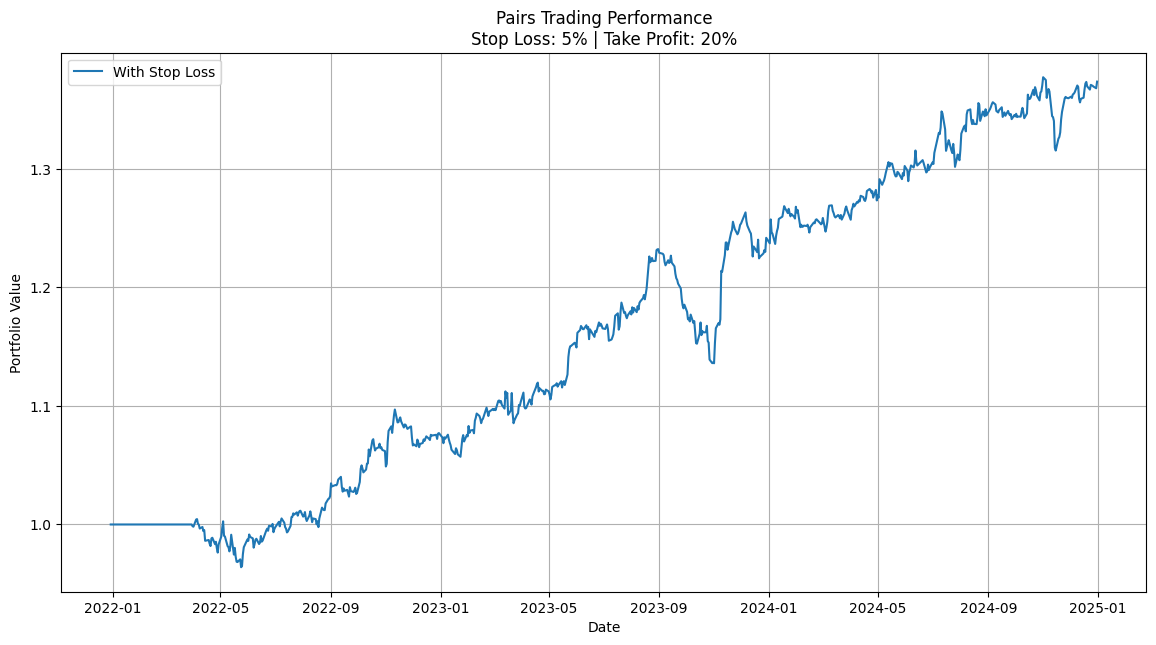

In [48]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Basic Z-Score Model

# Initialize pair_dfs
pair_dfs = {}
upper_threshold = 1.28  # Z-score for short entry
lower_threshold = -1.28  # Z-score for long entry
exit_threshold = 0.4  # Z-score for exit
capital = 1.0  # Starting capital per pair
positions = {}  # To store positions for each pair

# Enhanced risk management parameters
max_position_size = 1  # Max capital allocation per pair
stop_loss_pct = 0.05  # 10% stop loss
take_profit_pct = 0.2  # 20% take profit

# Loop through each pair with enhanced error handling
for ticker1, ticker2 in zip(filtered_pairs_df['Asset1'], filtered_pairs_df['Asset2']):
    try:
        # Data preparation
        pair_df = test_data.loc[:, [ticker1, ticker2]].copy()
        pair_df = pair_df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

        if len(pair_df.dropna()) < 30:
            continue

        # Log transform prices
        with np.errstate(all='ignore'):
            pair_df[f'log_{ticker1}'] = np.log(pair_df[ticker1])
            pair_df[f'log_{ticker2}'] = np.log(pair_df[ticker2])
        pair_df = pair_df.dropna()

        # Calculate hedge ratio
        y = pair_df[f'log_{ticker2}']
        x = pair_df[f'log_{ticker1}']
        model = sm.OLS(y, sm.add_constant(x)).fit()
        hedge_ratio = model.params[1]

        # Spread calculation
        pair_df['spread'] = y - hedge_ratio * x
        lookback = min(63, len(pair_df)//2)
        pair_df['spread_mean'] = pair_df['spread'].rolling(lookback).mean()
        pair_df['spread_std'] = pair_df['spread'].rolling(lookback).std()
        pair_df['z_score'] = (pair_df['spread'] - pair_df['spread_mean']) / pair_df['spread_std']

        # Initialize position tracking
        pair_df['Position'] = 0
        pair_df['Entry_Value'] = np.nan  # Track value at entry
        pair_df['Current_Value'] = np.nan  # Track current position value
        position_state = 0
        entry_value = 0

        for i in range(1, len(pair_df)):
            current_z = pair_df['z_score'].iloc[i]
            prev_pos = pair_df['Position'].iloc[i-1]

            # Calculate hedged returns
            ret1 = pair_df[ticker1].iloc[i] / pair_df[ticker1].iloc[i-1] - 1
            ret2 = pair_df[ticker2].iloc[i] / pair_df[ticker2].iloc[i-1] - 1
            hedged_ret = ret2 - hedge_ratio * ret1

            # Entry conditions
            if prev_pos == 0:
                if current_z > upper_threshold:
                    position_state = -1  # Short spread
                    entry_value = 1.0  # Normalized entry value
                elif current_z < lower_threshold:
                    position_state = 1  # Long spread
                    entry_value = 1.0

                if position_state != 0:
                    pair_df['Entry_Value'].iloc[i] = entry_value

            # Position management
            elif prev_pos != 0:
                # Update current position value
                current_value = entry_value * (1 + hedged_ret * prev_pos)
                pair_df['Current_Value'].iloc[i] = current_value

                # Check stop loss
                if (position_state == 1 and current_value < 1 - stop_loss_pct) or \
                   (position_state == -1 and current_value < 1 - stop_loss_pct):
                    position_state = 0
                    pair_df['Current_Value'].iloc[i] = 1 - stop_loss_pct  # Record exit value

                # Check take profit
                elif current_value > 1 + take_profit_pct:
                    position_state = 0
                    pair_df['Current_Value'].iloc[i] = 1 + take_profit_pct

                # Check z-score exit
                elif (prev_pos == -1 and current_z < exit_threshold) or \
                     (prev_pos == 1 and current_z > -exit_threshold):
                    position_state = 0

            pair_df['Position'].iloc[i] = position_state

            # Reset entry value if exited
            if position_state == 0:
                entry_value = 0

        # Calculate strategy returns
        pair_df['hedged_returns'] = pair_df[ticker2].pct_change() - hedge_ratio * pair_df[ticker1].pct_change()
        pair_df['strategy_return'] = pair_df['hedged_returns'] * pair_df['Position'].shift(1)
        pair_df['capital'] = capital * (1 + pair_df['strategy_return']).cumprod()

        # Store results
        pair_dfs[f'{ticker1}_{ticker2}'] = pair_df

    except Exception as e:
        print(f"Error processing {ticker1}-{ticker2}: {str(e)}")
        continue

# Portfolio construction with quality-based allocation
if pair_dfs:
    all_returns = pd.concat([df['strategy_return'] for df in pair_dfs.values()], axis=1)
    all_returns.columns = pair_dfs.keys()

    # Apply quality-based scaling
    for i, pair in enumerate(all_returns.columns):
        all_returns[pair] *= filtered_pairs_df.loc[i, 'Scaled_Quality']

    portfolio_returns = all_returns.sum(axis=1)
    portfolio_capital = (1 + portfolio_returns).cumprod()

    # Enhanced performance reporting
    print("\nStrategy Performance Metrics:")
    print(f"Stop Loss: {stop_loss_pct:.0%} | Take Profit: {take_profit_pct:.0%}")
    print(f"Final Return: {portfolio_capital.iloc[-1] - 1:.2%}")
    print(f"Annualized Sharpe: {portfolio_returns.mean()/portfolio_returns.std()*np.sqrt(252):.2f}")
    print(f"Max Drawdown: {(portfolio_capital/portfolio_capital.cummax()-1).min():.2%}")

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_capital, label='With Stop Loss')
    plt.title(f"Pairs Trading Performance\nStop Loss: {stop_loss_pct:.0%} | Take Profit: {take_profit_pct:.0%}")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()


CAC-DCOM Model Performance:
Train Accuracy: 85.08%
Test Accuracy: 74.72%

BDX-BMY Model Performance:
Train Accuracy: 79.70%
Test Accuracy: 69.89%

BDX-MRK Model Performance:
Train Accuracy: 80.52%
Test Accuracy: 57.32%

NHC-UBFO Model Performance:
Train Accuracy: 81.49%
Test Accuracy: 68.78%

INGR-PLUS Model Performance:
Train Accuracy: 82.18%
Test Accuracy: 70.99%

ARTNA-SAMG Model Performance:
Train Accuracy: 80.52%
Test Accuracy: 73.20%

BDX-PFE Model Performance:
Train Accuracy: 76.52%
Test Accuracy: 54.42%

BSRR-IBCP Model Performance:
Train Accuracy: 81.22%
Test Accuracy: 63.67%

NBTB-NFBK Model Performance:
Train Accuracy: 79.28%
Test Accuracy: 60.50%

COLM-TPR Model Performance:
Train Accuracy: 75.83%
Test Accuracy: 67.54%

GENC-NL Model Performance:
Train Accuracy: 80.80%
Test Accuracy: 60.64%

FCBC-HAFC Model Performance:
Train Accuracy: 78.73%
Test Accuracy: 66.16%

HUBB-PWR Model Performance:
Train Accuracy: 77.07%
Test Accuracy: 70.99%

MLAB-NSSC Model Performance:
Train 

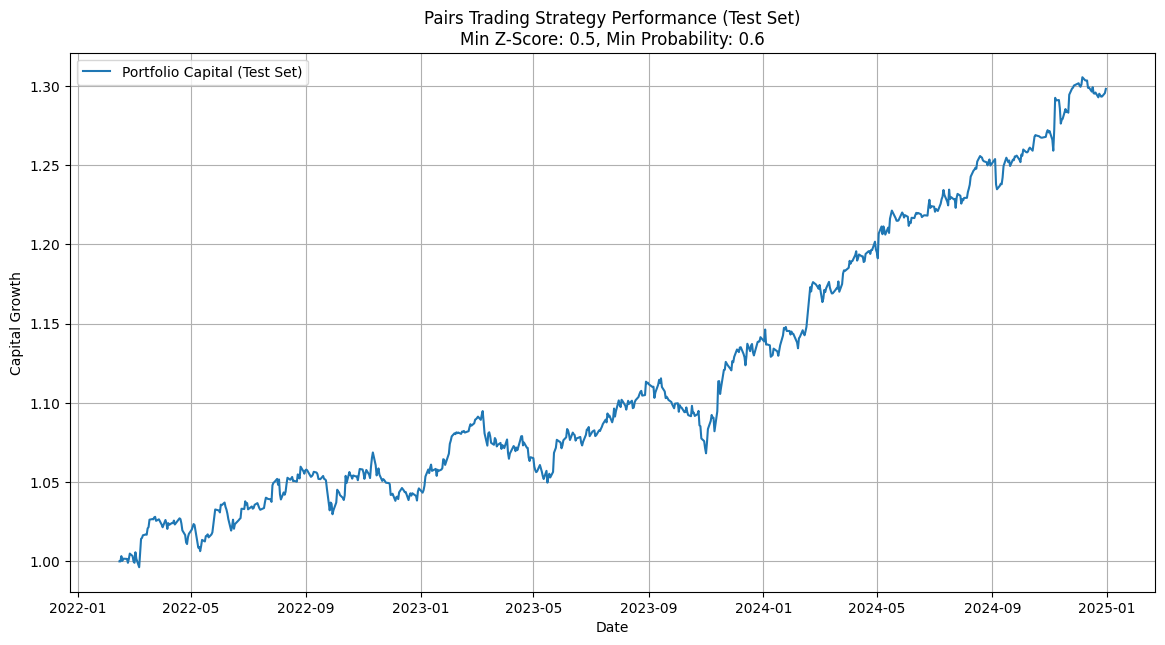


Test Set Strategy Performance Metrics:
Total Return: 29.80%
Annualized Return: 9.23%
Max Drawdown: -4.24%
Sharpe Ratio: 1.68
Win Rate: 52.76%
Number of Trades: 722


In [49]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Including XGBoost to determine when to enter into positions
## trying to identify the likelihood of spread reverting 20 days from now

# Initialize pair_dfs
pair_dfs = {}
capital = 1.0
max_position_size = 1

# XGBoost model parameters
xgb_params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 400,
    'early_stopping_rounds': 10
}

# Initialize portfolio metrics storage
portfolio_test_returns = []

# Trading parameters
min_zscore_threshold = 0.5  # Minimum absolute z-score to trade
min_proba_threshold = 0.6  # Minimum probability to trade

# Loop through each pair with XGBoost integration
for ticker1, ticker2 in zip(filtered_pairs_df['Asset1'], filtered_pairs_df['Asset2']):
    try:
        # Extract and clean data
        pair_df = full_data.loc[:, [ticker1, ticker2]].copy()
        pair_df = pair_df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

        if len(pair_df.dropna()) < 200:  # Need sufficient data for proper train/test split
            print(f"Skipping {ticker1}-{ticker2}: insufficient data")
            continue

        # Calculate log prices
        with np.errstate(all='ignore'):
            pair_df[f'log_{ticker1}'] = np.log(pair_df[ticker1])
            pair_df[f'log_{ticker2}'] = np.log(pair_df[ticker2])

        pair_df = pair_df.dropna()

        # Prepare regression variables
        y_log = pair_df[f'log_{ticker2}']
        x_log = pair_df[f'log_{ticker1}']
        X_reg = sm.add_constant(x_log)

        # Calculate hedge ratio using all data
        model = sm.OLS(y_log, X_reg, missing='drop').fit()
        beta = model.params[1]
        hedge_ratio = beta

        # Feature engineering
        pair_df['spread'] = y_log - hedge_ratio * x_log
        lookback = min(63, len(pair_df)//2)

        pair_df['spread_mean'] = pair_df['spread'].rolling(window=lookback).mean()
        pair_df['spread_std'] = pair_df['spread'].rolling(window=lookback).std()
        pair_df['z_score'] = (pair_df['spread'] - pair_df['spread_mean']) / pair_df['spread_std']

        pair_df['ma_10'] = pair_df['spread'].rolling(window=10).mean()
        pair_df['ma_30'] = pair_df['spread'].rolling(window=30).mean()
        pair_df['momentum'] = pair_df['spread'] - pair_df['spread'].shift(5)
        pair_df['volatility'] = pair_df['spread'].rolling(window=20).std()

        # Calculate returns and target variable
        pair_df['asset1_returns'] = pair_df[ticker1].pct_change()
        pair_df['asset2_returns'] = pair_df[ticker2].pct_change()
        pair_df['hedged_returns'] = pair_df['asset2_returns'] - hedge_ratio * pair_df['asset1_returns']
        pair_df['target'] = (pair_df['z_score'].shift(-20) - pair_df['z_score'] > 0).astype(int)
        #pair_df['target'] = (pair_df['hedged_returns'].shift(-20) > 0).astype(int)
        pair_df = pair_df.dropna()

        # Prepare features for XGBoost
        features = ['z_score', 'ma_10', 'ma_30', 'momentum', 'volatility',
                   'spread_mean', 'spread_std']
        X = pair_df[features]
        y = pair_df['target']

        # Time-series train-test split (80-20)
        split_idx = int(len(pair_df) * 0.5)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train XGBoost model
        xgb_model = xgb.XGBClassifier(**xgb_params)
        xgb_model.fit(X_train_scaled, y_train,
                     eval_set=[(X_test_scaled, y_test)],
                     verbose=False)

        # Model evaluation
        train_preds = xgb_model.predict(X_train_scaled)
        test_preds = xgb_model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, test_preds)

        print(f"\n{ticker1}-{ticker2} Model Performance:")
        print(f"Train Accuracy: {train_acc:.2%}")
        print(f"Test Accuracy: {test_acc:.2%}")
        #print("\nTest Set Classification Report:")
        #print(classification_report(y_test, test_preds))

        # Apply model only to test set for trading
        test_df = pair_df.iloc[split_idx:].copy()
        X_test_all = test_df[features]
        X_test_scaled = scaler.transform(X_test_all)

        test_df['pred_proba'] = xgb_model.predict_proba(X_test_scaled)[:, 1]
        test_df['prediction'] = xgb_model.predict(X_test_scaled)

        # Position management with both XGBoost and z-score filters
        test_df['Position'] = 0
        position_state = 0

        for i in range(1, len(test_df)):
            current_pred = test_df['prediction'].iloc[i]
            current_proba = test_df['pred_proba'].iloc[i]
            current_z = test_df['z_score'].iloc[i]
            #print(current_proba)

            # Entry conditions - must meet both probability and z-score thresholds
            if position_state == 0:
                if (current_proba > min_proba_threshold and
                    current_z > min_zscore_threshold and
                    current_pred == 0):
                    position_state = -1  # Short
                elif (current_proba > 1-min_proba_threshold and
                      current_z < -min_zscore_threshold and
                      current_pred == 1):
                    position_state = 1  # Long

            # Exit conditions
            elif position_state != 0:
                if(  (position_state == -1 and current_z < 0.3) or
                    (position_state == 1 and current_z > -0.3)):
                    position_state = 0



            test_df['Position'].iloc[i] = position_state

        # Calculate strategy returns (test set only)
        test_df['strategy_return'] = test_df['hedged_returns'] * test_df['Position'].shift(1)
        test_df['capital'] = capital * (1 + test_df['strategy_return'] * max_position_size).cumprod()

        # Store test set results for portfolio calculation
        portfolio_test_returns.append(test_df['strategy_return'])
        pair_dfs[f'{ticker1}_{ticker2}'] = test_df

    except Exception as e:
        print(f"Error processing {ticker1}-{ticker2}: {str(e)}")
        continue

# Portfolio performance calculation (test set only)
if portfolio_test_returns:
    portfolio_test_returns = pd.concat(portfolio_test_returns, axis=1)
    portfolio_test_returns.columns = list(pair_dfs.keys())
    for i in range(0, portfolio_test_returns.shape[1]):
        portfolio_test_returns.iloc[:, i] *= filtered_pairs_df.loc[i, 'Scaled_Quality']
    portfolio_returns = portfolio_test_returns.sum(axis=1)
    #portfolio_returns = portfolio_test_returns.mean(axis=1)
    portfolio_capital = (1 + portfolio_returns).cumprod()

    # Plotting test set performance
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_capital, label='Portfolio Capital (Test Set)')
    plt.title(f"Pairs Trading Strategy Performance (Test Set)\nMin Z-Score: {min_zscore_threshold}, Min Probability: {min_proba_threshold}")
    plt.xlabel('Date')
    plt.ylabel('Capital Growth')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Performance metrics (test set only)
    print("\nTest Set Strategy Performance Metrics:")
    print(f"Total Return: {portfolio_capital.iloc[-1] - 1:.2%}")
    print(f"Annualized Return: {portfolio_returns.mean() * 252:.2%}")
    print(f"Max Drawdown: {(portfolio_capital / portfolio_capital.cummax() - 1).min():.2%}")
    print(f"Sharpe Ratio: {portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252):.2f}")
    print(f"Win Rate: {len(portfolio_returns[portfolio_returns > 0]) / len(portfolio_returns):.2%}")
    print(f"Number of Trades: {(portfolio_returns != 0).sum()}")
else:
    print("No valid pairs were processed - check your input data and filters")


CAC-DCOM Model Performance:
Train Accuracy: 83.98%
Test Accuracy: 70.72%

BDX-BMY Model Performance:
Train Accuracy: 74.59%
Test Accuracy: 71.41%

BDX-MRK Model Performance:
Train Accuracy: 82.18%
Test Accuracy: 57.73%

NHC-UBFO Model Performance:
Train Accuracy: 75.00%
Test Accuracy: 69.20%

INGR-PLUS Model Performance:
Train Accuracy: 76.93%
Test Accuracy: 74.03%

ARTNA-SAMG Model Performance:
Train Accuracy: 78.31%
Test Accuracy: 71.27%

BDX-PFE Model Performance:
Train Accuracy: 82.18%
Test Accuracy: 61.46%

BSRR-IBCP Model Performance:
Train Accuracy: 79.14%
Test Accuracy: 52.49%

NBTB-NFBK Model Performance:
Train Accuracy: 68.92%
Test Accuracy: 56.08%

COLM-TPR Model Performance:
Train Accuracy: 68.65%
Test Accuracy: 70.17%

GENC-NL Model Performance:
Train Accuracy: 72.79%
Test Accuracy: 68.92%

FCBC-HAFC Model Performance:
Train Accuracy: 73.90%
Test Accuracy: 74.86%

HUBB-PWR Model Performance:
Train Accuracy: 73.90%
Test Accuracy: 73.90%

MLAB-NSSC Model Performance:
Train 

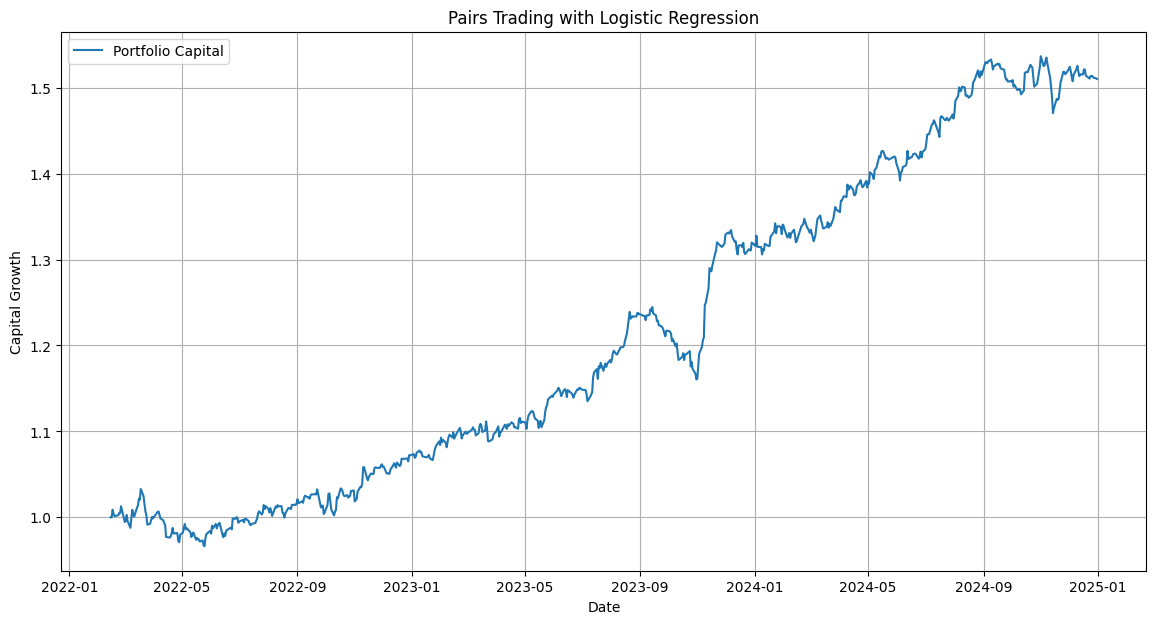


Strategy Performance Metrics:
Total Return: 51.01%
Annualized Return: 14.67%
Max Drawdown: -6.77%
Sharpe Ratio: 1.83


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Including Logistic Regression to determine when to enter into positions
## trying to identify the likelihood of spread reverting 20 days from now

# Initialize pair_dfs
pair_dfs = {}
capital = 1.0
max_position_size = 1

# Logistic Regression parameters
logreg_params = {
    'penalty': 'l2',  # Ridge regularization
    'C': 1.0,         # Inverse of regularization strength
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': 42
}

# Initialize portfolio metrics storage
portfolio_test_returns = []

# Trading parameters
min_zscore_threshold = 0.5
min_proba_threshold = 0.6 # extra criteria to ensure that we are more certain that the spread will revert
exit_proba_threshold = 0.52

# Loop through each pair with Logistic Regression integration
for ticker1, ticker2 in zip(filtered_pairs_df['Asset1'], filtered_pairs_df['Asset2']):
    try:
        # Extract and clean data
        pair_df = full_data.loc[:, [ticker1, ticker2]].copy()
        pair_df = pair_df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

        if len(pair_df.dropna()) < 200:
            print(f"Skipping {ticker1}-{ticker2}: insufficient data")
            continue

        # Calculate log prices
        with np.errstate(all='ignore'):
            pair_df[f'log_{ticker1}'] = np.log(pair_df[ticker1])
            pair_df[f'log_{ticker2}'] = np.log(pair_df[ticker2])
        pair_df = pair_df.dropna()

        # Calculate hedge ratio
        y_log = pair_df[f'log_{ticker2}']
        x_log = pair_df[f'log_{ticker1}']
        model = sm.OLS(y_log, sm.add_constant(x_log)).fit()
        hedge_ratio = model.params[1]

        # Feature engineering
        pair_df['spread'] = y_log - hedge_ratio * x_log
        lookback = min(63, len(pair_df)//2)

        pair_df['spread_mean'] = pair_df['spread'].rolling(lookback).mean()
        pair_df['spread_std'] = pair_df['spread'].rolling(lookback).std()
        pair_df['z_score'] = (pair_df['spread'] - pair_df['spread_mean']) / pair_df['spread_std']

        pair_df['ma_10'] = pair_df['spread'].rolling(10).mean()
        pair_df['ma_30'] = pair_df['spread'].rolling(30).mean()
        pair_df['momentum'] = pair_df['spread'] - pair_df['spread'].shift(5)
        pair_df['volatility'] = pair_df['spread'].rolling(20).std()

        # Target variable
        pair_df['hedged_returns'] = pair_df[ticker2].pct_change() - hedge_ratio * pair_df[ticker1].pct_change()
        pair_df['target'] = (pair_df['z_score'].shift(-20) - pair_df['z_score'] > 0).astype(int)
        #pair_df['target'] = (pair_df['hedged_returns'].shift(-40) > 0).astype(int)
        pair_df = pair_df.dropna()

        # Prepare features
        features = ['z_score', 'ma_10', 'ma_30', 'momentum', 'volatility',
                   'spread_mean', 'spread_std']
        X = pair_df[features]
        y = pair_df['target']

        # Time-series split
        split_idx = int(len(pair_df) * 0.5)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train Logistic Regression model
        lr_model = LogisticRegression(**logreg_params)
        lr_model.fit(X_train_scaled, y_train)

        # Model evaluation
        train_preds = lr_model.predict(X_train_scaled)
        test_preds = lr_model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, test_preds)

        print(f"\n{ticker1}-{ticker2} Model Performance:")
        print(f"Train Accuracy: {train_acc:.2%}")
        print(f"Test Accuracy: {test_acc:.2%}")

        # Apply model to test set
        test_df = pair_df.iloc[split_idx:].copy()
        X_test_all = test_df[features]
        X_test_scaled = scaler.transform(X_test_all)

        test_df['pred_proba'] = lr_model.predict_proba(X_test_scaled)[:, 1]
        test_df['prediction'] = lr_model.predict(X_test_scaled)

        # Position management
        test_df['Position'] = 0
        position_state = 0

        for i in range(1, len(test_df)):
            current_pred = test_df['prediction'].iloc[i]
            current_proba = test_df['pred_proba'].iloc[i]
            current_z = test_df['z_score'].iloc[i]

            # Entry conditions
            short_prob = 1 - current_proba  # Probability of class 0
            long_prob = current_proba       # Probability of class 1

            if position_state == 0:
              if (short_prob > min_proba_threshold and
                  current_z > min_zscore_threshold and
                  current_pred == 0):
                    position_state = -1
              elif (long_prob > min_proba_threshold and
                  current_z < -min_zscore_threshold and
                  current_pred == 1):
                    position_state = 1

            # Exit conditions
            elif position_state != 0:
                  if  ((position_state == -1 and current_z < 0.1) or (position_state == -1 and short_prob < min_proba_threshold) or
                    (position_state == 1 and current_z > -0.1) or (position_state == 1 and long_prob < min_proba_threshold)):
                    position_state = 0

            test_df['Position'].iloc[i] = position_state

        # Calculate strategy returns
        test_df['strategy_return'] = test_df['hedged_returns'] * test_df['Position'].shift(1)
        test_df['capital'] = capital * (1 + test_df['strategy_return'] * max_position_size).cumprod()

        # Store results
        portfolio_test_returns.append(test_df['strategy_return'])
        pair_dfs[f'{ticker1}_{ticker2}'] = test_df

    except Exception as e:
        print(f"Error processing {ticker1}-{ticker2}: {str(e)}")
        continue

# Portfolio performance calculation
if portfolio_test_returns:
    portfolio_test_returns = pd.concat(portfolio_test_returns, axis=1)
    portfolio_test_returns.columns = list(pair_dfs.keys())

    # Apply quality-based scaling
    for i in range(portfolio_test_returns.shape[1]):
        portfolio_test_returns.iloc[:, i] *= filtered_pairs_df.loc[i, 'Scaled_Quality']

    portfolio_returns = portfolio_test_returns.sum(axis=1)
    portfolio_capital = (1 + portfolio_returns).cumprod()

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_capital, label='Portfolio Capital')
    plt.title("Pairs Trading with Logistic Regression")
    plt.xlabel('Date')
    plt.ylabel('Capital Growth')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Performance metrics
    print("\nStrategy Performance Metrics:")
    print(f"Total Return: {portfolio_capital.iloc[-1] - 1:.2%}")
    print(f"Annualized Return: {portfolio_returns.mean() * 252:.2%}")
    print(f"Max Drawdown: {(portfolio_capital/portfolio_capital.cummax()-1).min():.2%}")
    print(f"Sharpe Ratio: {portfolio_returns.mean()/portfolio_returns.std()*np.sqrt(252):.2f}")
else:
    print("No valid pairs were processed")